In [1]:
# Add anna to the path
import os
import sys
module_path = os.path.abspath(os.path.join('../../../anna'))
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_DIR = "../../../data"

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import anna.data.dataset.fullrcv1 as rcv1
import anna.model.premade as models
import anna.model.trainer as trainer
import anna.summary.extract as summary
import anna.summary.plots as plots

tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [3]:
# Load data
train_docs, test_docs, unused_docs, labels = rcv1.fetch_and_parse(DATA_DIR)

# Standard RCV1 Config
val_size = 75000
epochs = 5
shuffle = 750000

In [4]:
val_docs = train_docs.take(val_size)
train_docs = train_docs.skip(val_size)

def val_input():
    return trainer.input_fn(val_docs, batch_size=32)

all_models = []
for beam in [0, 2, 4, 8, 12, 20]:
    all_models.append((beam, models.EncDec(DATA_DIR, labels,
                                           beam_width=beam,
                                           input_limit=20,
                                           folder_name="model-beam")))

for i in range(epochs):
    all_models[0][1].train(docs=train_docs,
                           test_docs=None,
                           val_size=0,
                           epochs=None,
                           shuffle=shuffle)
    for beam, m in all_models:
        m.estimator.evaluate(val_input, name=str(beam))

In [5]:
model_path = os.path.join(DATA_DIR, "model-beam")
enc_path = os.path.join(model_path, "enc_dec")
metrics_path = os.path.join(model_path, "metrics.json")

In [6]:
# Load from tfrecord event files
models = [(e.name, e.path) for e in os.scandir(enc_path) if e.is_dir()]
metrics = {}
for name, path in models:
    name = name[len("eval_"):]
    events = summary.find_events(path)
    metrics[name] = summary.get_metrics(events)
with open(metrics_path, "w") as f:
    json.dump(metrics, f)

In [7]:
# Load from json serialized metrics
#with open(metrics_path, "r") as f:
#    metrics = json.load(f)

In [8]:
num_epochs = min([len(m["perf/accuracy"]) for m in metrics.values()])

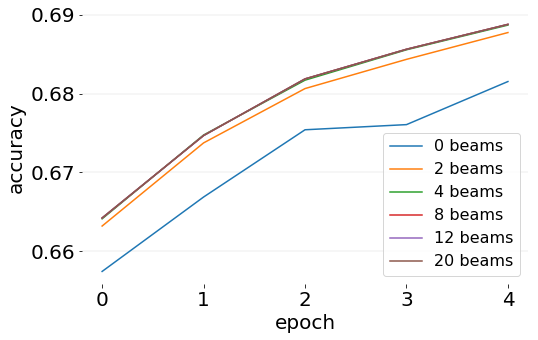

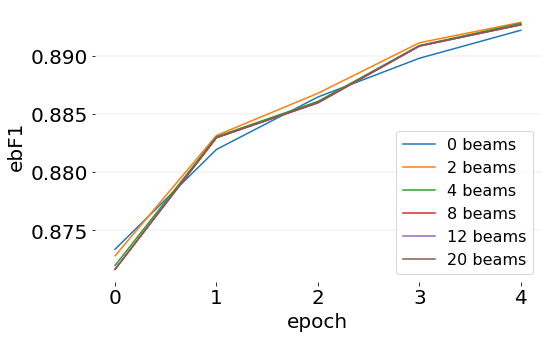

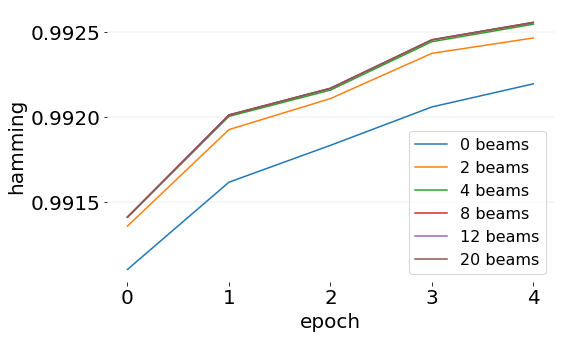

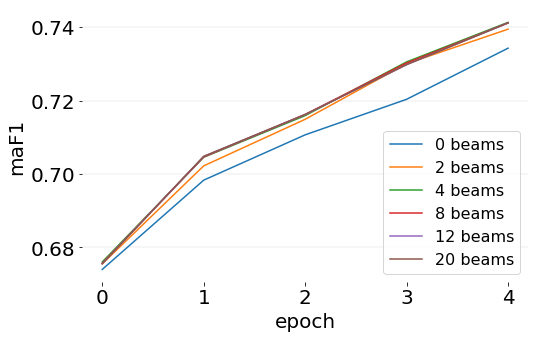

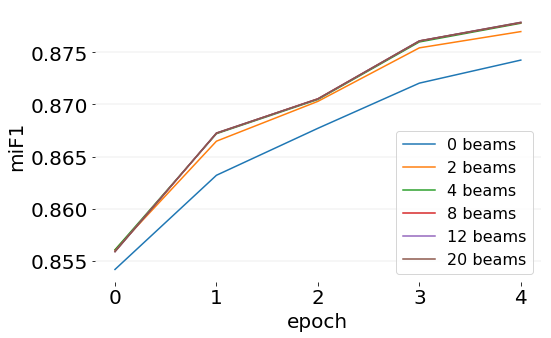

In [9]:
x = range(num_epochs)
for metric_name in ["perf/accuracy", "perf/ebF1", "perf/hamming", "perf/maF1", "perf/miF1"]:
    pre, ax = plots.subplots(figsize=[8, 5], xlabel="epoch", ylabel=metric_name[len("perf/"):])

    i = 0
    for name, metric in sorted(metrics.items(), key=lambda t: int(t[0])):
        y = metric[metric_name][:num_epochs]
        y = [m[1] for m in y]
        plots.plot(ax, x, y, color=i, label="{} beams".format(name))
        i += 2

    ax.legend(loc=4, fontsize=16)